# Settings

In [1]:
import sys

# set lib path just next to current path to give priority to modules in lib
sys.path.insert(sys.path.index('')+1, '/lib')

In [2]:
%load_ext autotime

import pandas as pd
import FinanceDataReader as fdr

from lib.fastquant import backtest_portfolio
from lib.utils import HiddenPrints, DATE_FORMAT
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np

time: 6.79 s (started: 2023-02-23 12:18:40 +09:00)


In [3]:
start = '20180101'
end = '20221231'

symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

time: 261 ms (started: 2023-02-23 12:18:47 +09:00)


In [4]:
def run_backtest(start, df_bt, kwargs, proba=1, strategy='custom'):
    
    df = df_bt.copy()
    end = start + timedelta(hold_period)
    df = df.loc[start:end]
    if proba < 1:
        df.loc[:,'custom'] = df.custom.apply(lambda x:x*np.random.choice(2, 1, p=[1.-proba, proba])[0])
    df = {symbol: df}
    with HiddenPrints(mark_end=False):
        result = backtest_portfolio(strategy, df, start.strftime(DATE_FORMAT), end.strftime(DATE_FORMAT), **kwargs)
    #return result # testing
        
    #if np.isnan(result['history']['win_rate'].squeeze()):
    if result['history']['len'].squeeze() == 0:
        #return [start, end, None, None, None] # last col 'return' cast to NaT instead of None 
        return [start, end, -1, None, None]
    else:
        return [start, end] + result['summary']
    

def print_progress(i, print_step, last_print):
    n = round((i+1) / n_dates * 100)
    if n != last_print and n % (print_step*100) == 0:
        print(f'{n}% done')
        return n
    else:
        return last_print

time: 2.31 ms (started: 2023-02-23 12:18:48 +09:00)


In [5]:
df_compare = pd.DataFrame()

time: 1.62 ms (started: 2023-02-23 12:18:48 +09:00)


# Buy & hold

## Settings

In [6]:
df_bt = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt.index

time: 7.12 ms (started: 2023-02-23 12:18:48 +09:00)


In [7]:
hold_period = 365
dates_start = df_bt.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 7.68 ms (started: 2023-02-23 12:18:49 +09:00)


In [8]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 7.1 ms (started: 2023-02-23 12:18:49 +09:00)


In [9]:
# testing
#dates_start = dates_start[:50]

time: 6.51 ms (started: 2023-02-23 12:18:50 +09:00)


## SC01

In [10]:
scenario = 'b1'
n_buy = 1

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1e+03 µs (started: 2023-02-23 12:18:51 +09:00)


In [11]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    df_bt.loc[start,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 13min 6s (started: 2023-02-23 12:18:52 +09:00)


In [12]:
df_result['return'].agg(['mean','min','max'])

mean      6.723509
min     -29.578320
max     111.056006
Name: return, dtype: float64

time: 19.3 ms (started: 2023-02-23 12:31:58 +09:00)


In [13]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 10.9 ms (started: 2023-02-23 12:31:58 +09:00)


## SC02

In [14]:
scenario = 'b2'
n_buy = 10

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 7.29 ms (started: 2023-02-23 12:32:42 +09:00)


In [15]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 20

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 14min (started: 2023-02-23 12:32:45 +09:00)


In [16]:
df_result['return'].agg(['mean','min','max'])

mean     2.625810
min    -16.512425
max     38.402674
Name: return, dtype: float64

time: 21.3 ms (started: 2023-02-23 12:46:46 +09:00)


In [17]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 22.4 ms (started: 2023-02-23 12:46:46 +09:00)


## SC03

In [18]:
scenario = 'b3'
n_buy = 20

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.06 ms (started: 2023-02-23 12:46:46 +09:00)


In [19]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 10

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 15min 10s (started: 2023-02-23 12:46:46 +09:00)


In [20]:
df_result['return'].agg(['mean','min','max'])

mean     2.453650
min    -16.298809
max     36.055343
Name: return, dtype: float64

time: 21 ms (started: 2023-02-23 13:01:56 +09:00)


In [21]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 18.3 ms (started: 2023-02-23 13:01:56 +09:00)


## Compare

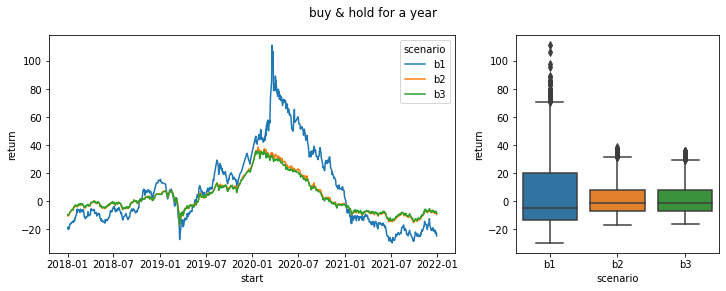

time: 1.35 s (started: 2023-02-23 13:01:56 +09:00)


In [23]:
fig = plt.figure(figsize=(12, 4))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

df = df_compare.dropna(subset='return').reset_index()
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1)
_ = sns.boxplot(data=df, x='scenario', y='return', ax=ax2)

# Technical Indicator

## Settings

In [24]:
import tulipy as ti

time: 17.2 ms (started: 2023-02-23 13:02:30 +09:00)


In [25]:
def calc_macd(df, periods=[12,26,9]):
    ind = ti.macd(df.astype(float).to_numpy(), *periods)

    name = 'macd'
    cols = [name, name+'_signal', name+'_histogram']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def calc_bbands(df, periods=[20,2]):
    ind = ti.bbands(df.astype(float).to_numpy(), *periods)

    name = 'bbands'
    cols = [name+'_lower', name+'_middle', name+'_upper']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def finish_custom(df_bt):
    df = df_bt.copy()
    prv = 0
    for dt, (_, c) in df.iterrows():
        if c in [1, -1]:
            if c == prv:
                df.loc[dt, 'custom'] = 0
            else:
                prv = c
        else:
            prv = 0
    return df


def check_scenario(idx_nobuy, i=None, df_result=None):
    if df_result is None:
        n = len(idx_nobuy)
        if n > 0:
            print(f'{n} scenarios of no buy.')
        return None
    if pd.isnull(df_result.loc[i]['return']):
        idx_nobuy.append(i)
        n = len(idx_nobuy)
        if n < 2:
            print(f'{i}: No buy at all')
        elif n == 2:
            print('there are more scenarios of no buy.')
        else:
            pass
    return idx_nobuy

time: 3.78 ms (started: 2023-02-23 13:02:31 +09:00)


In [75]:
df_bt_ori = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt_ori.index

time: 12.9 ms (started: 2023-02-23 14:48:52 +09:00)


In [76]:
hold_period = 365
dates_start = df_bt_ori.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 3.03 ms (started: 2023-02-23 14:48:53 +09:00)


In [31]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 1.08 ms (started: 2023-02-23 13:02:54 +09:00)


In [32]:
# testing
#dates_start = dates_start[400:500]

time: 642 µs (started: 2023-02-23 13:02:55 +09:00)


## SC01: MACD

### calc tech indi

In [78]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])

time: 10.6 ms (started: 2023-02-23 14:49:23 +09:00)


In [34]:
df_ti = df_macd

cond = (df_ti.macd > df_ti.macd_signal) 
cond = cond & (df_ti.macd > 0)
df_bt.loc[cond, 'custom'] = -1

cond = (df_ti.macd < df_ti.macd_signal) 
cond = cond & (df_ti.macd < 0)
df_bt.loc[cond, 'custom'] = 1

time: 11.8 ms (started: 2023-02-23 13:02:57 +09:00)


In [35]:
df_bt = finish_custom(df_bt)

time: 373 ms (started: 2023-02-23 13:02:58 +09:00)


In [36]:
# small number of chance to buy
df_bt.custom.value_counts()

 0    1161
 1      38
-1      33
Name: custom, dtype: int64

time: 10.4 ms (started: 2023-02-23 13:02:58 +09:00)


### bactesting 1

In [37]:
scenario = 't1a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 990 µs (started: 2023-02-23 13:03:02 +09:00)


In [39]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
20 % done
255: No buy at all
there are more scenarios of no buy.
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
40 scenarios of no buy.
time: 16min 39s (started: 2023-02-23 13:03:52 +09:00)


In [40]:
df_result['return'].agg(['mean','min','max'])

mean     7.291352
min    -12.013608
max     57.532363
Name: return, dtype: float64

time: 14.3 ms (started: 2023-02-23 13:20:32 +09:00)


In [41]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 15.4 ms (started: 2023-02-23 13:20:32 +09:00)


### bactesting 2

In [42]:
scenario = 't1b'

kwargs_bt.update({
    'buy_prop': 0.5,
    'sell_prop': 0.5
})

time: 1.01 ms (started: 2023-02-23 13:20:32 +09:00)


In [43]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
20 % done
258: No buy at all
30 % done
there are more scenarios of no buy.
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
33 scenarios of no buy.
time: 18min 49s (started: 2023-02-23 13:20:32 +09:00)


In [44]:
df_result['return'].agg(['mean','min','max'])

mean     4.238674
min     -6.153420
max     36.403294
Name: return, dtype: float64

time: 14.5 ms (started: 2023-02-23 13:39:21 +09:00)


In [45]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13.7 ms (started: 2023-02-23 13:39:21 +09:00)


### bactesting 3

In [46]:
scenario = 't1c'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

time: 1.15 ms (started: 2023-02-23 13:39:21 +09:00)


In [47]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
20 % done
213: No buy at all
there are more scenarios of no buy.
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
25 scenarios of no buy.
time: 21min 46s (started: 2023-02-23 13:39:21 +09:00)


In [48]:
df_result['return'].agg(['mean','min','max'])

mean     1.731516
min     -3.162596
max     16.136710
Name: return, dtype: float64

time: 15.9 ms (started: 2023-02-23 14:01:08 +09:00)


In [49]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 12.3 ms (started: 2023-02-23 14:01:08 +09:00)


### bactesting 4

In [60]:
scenario = 't1d'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

proba = 0.8

time: 1.21 ms (started: 2023-02-23 14:14:27 +09:00)


In [61]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt, proba)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

36: No buy at all
10 % done
20 % done
there are more scenarios of no buy.
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
42 scenarios of no buy.
time: 25min 38s (started: 2023-02-23 14:14:29 +09:00)


In [62]:
df_result['return'].agg(['mean','min','max'])

mean     6.535910
min    -18.098724
max     68.160862
Name: return, dtype: float64

time: 14.9 ms (started: 2023-02-23 14:40:08 +09:00)


In [63]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 16.4 ms (started: 2023-02-23 14:40:08 +09:00)


In [74]:
df_compare.to_csv('df_compare_5yrs.csv')

time: 224 ms (started: 2023-02-23 14:47:22 +09:00)


### compare

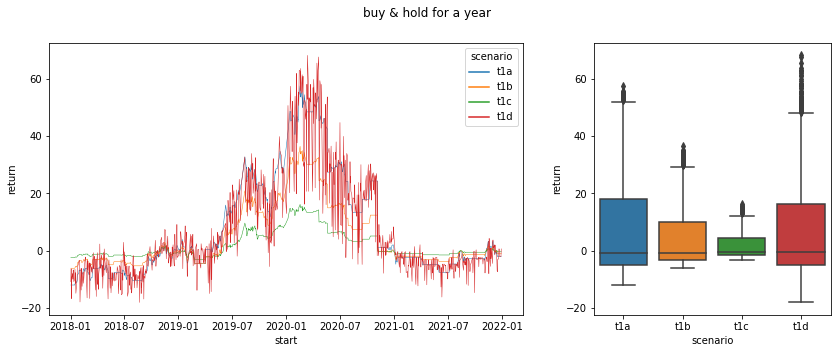

time: 1.39 s (started: 2023-02-23 17:23:01 +09:00)


In [105]:
fig = plt.figure(figsize=(14, 5))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
#fig.tight_layout()

df = (df_compare.loc[df_compare.scenario.str.startswith('t1')]
                .dropna(subset='return').reset_index())
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, x='scenario', y='return', ax=ax2)

## SC02: Bollinger Bands

### calc tech indi

In [79]:
df_bt = df_bt_ori.copy()
df_bbands = calc_bbands(df_bt['close'])
#df_bbands = calc_bbands(df_bt['close'], [20, 1])

time: 5.56 ms (started: 2023-02-23 14:49:34 +09:00)


In [80]:
df_ti = df_bbands

cond = df_bt.close < df_ti.bbands_lower
df_bt.loc[cond, 'custom'] = -1

cond = df_bt.close > df_ti.bbands_upper
df_bt.loc[cond, 'custom'] = 1

time: 8.15 ms (started: 2023-02-23 14:49:40 +09:00)


In [81]:
df_bt = finish_custom(df_bt)

time: 193 ms (started: 2023-02-23 14:49:42 +09:00)


In [82]:
df_bt.custom.value_counts()

 0    1157
-1      42
 1      33
Name: custom, dtype: int64

time: 18.3 ms (started: 2023-02-23 14:49:44 +09:00)


### bactesting 1

In [83]:
scenario = 't2a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 5.57 ms (started: 2023-02-23 14:50:05 +09:00)


In [84]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
107: No buy at all
there are more scenarios of no buy.
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
72 scenarios of no buy.
time: 29min 5s (started: 2023-02-23 14:50:07 +09:00)


In [85]:
df_result['return'].agg(['mean','min','max'])

mean    -2.072691
min    -25.756412
max     19.857751
Name: return, dtype: float64

time: 15.5 ms (started: 2023-02-23 15:19:12 +09:00)


In [86]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 11.4 ms (started: 2023-02-23 15:19:12 +09:00)


### bactesting 2

In [87]:
scenario = 't2b'

kwargs_bt.update({
    'buy_prop': 0.5,
    'sell_prop': 0.5
})

time: 1.03 ms (started: 2023-02-23 15:19:12 +09:00)


In [88]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10 % done
107: No buy at all
there are more scenarios of no buy.
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
79 scenarios of no buy.
time: 33min 50s (started: 2023-02-23 15:19:13 +09:00)


In [89]:
df_result['return'].agg(['mean','min','max'])

mean    -2.049049
min    -24.544178
max     13.797432
Name: return, dtype: float64

time: 12.8 ms (started: 2023-02-23 15:53:03 +09:00)


In [90]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13.9 ms (started: 2023-02-23 15:53:03 +09:00)


### bactesting 3

In [91]:
scenario = 't2c'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

time: 1.02 ms (started: 2023-02-23 15:53:03 +09:00)


In [92]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

62: No buy at all
there are more scenarios of no buy.
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
111 scenarios of no buy.
time: 38min 46s (started: 2023-02-23 15:53:04 +09:00)


In [93]:
df_result['return'].agg(['mean','min','max'])

mean    -1.976350
min    -20.921568
max      6.320392
Name: return, dtype: float64

time: 18.8 ms (started: 2023-02-23 16:31:50 +09:00)


In [94]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 22 ms (started: 2023-02-23 16:31:50 +09:00)


### bactesting 4

In [95]:
scenario = 't2d'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

proba = 0.5

time: 1.14 ms (started: 2023-02-23 16:31:50 +09:00)


In [96]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt, proba)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

17: No buy at all
there are more scenarios of no buy.
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
133 scenarios of no buy.
time: 45min (started: 2023-02-23 16:31:51 +09:00)


In [97]:
df_result['return'].agg(['mean','min','max'])

mean    -1.766146
min    -17.846510
max     10.629953
Name: return, dtype: float64

time: 19.8 ms (started: 2023-02-23 17:16:51 +09:00)


In [98]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 28.1 ms (started: 2023-02-23 17:16:51 +09:00)


In [99]:
df_compare.to_csv('df_compare_5yrs.csv')

time: 392 ms (started: 2023-02-23 17:17:40 +09:00)


### compare

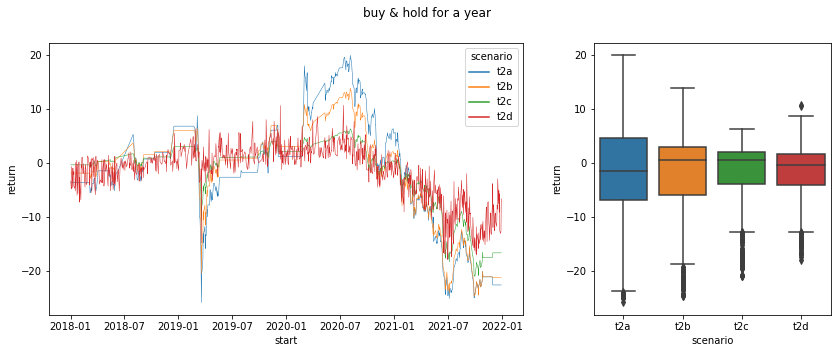

time: 1.36 s (started: 2023-02-23 17:21:49 +09:00)


In [104]:
fig = plt.figure(figsize=(14, 5))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
#fig.tight_layout()

df = (df_compare.loc[df_compare.scenario.str.startswith('t2')]
                .dropna(subset='return').reset_index())
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, x='scenario', y='return', ax=ax2)

## SC03: Bollinger Bands & MACD

### calc tech indi

In [106]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])
df_bbands = calc_bbands(df_bt['close'])

time: 11.1 ms (started: 2023-02-23 17:24:38 +09:00)


In [107]:
cond = (df_macd.macd > df_macd.macd_signal) & (df_macd.macd > 0)
cond = cond + (df_bt.close < df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = -1

cond = (df_macd.macd < df_macd.macd_signal) & (df_macd.macd < 0)
cond = cond + (df_bt.close > df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = 1

time: 14 ms (started: 2023-02-23 17:25:23 +09:00)


In [108]:
df_bt = finish_custom(df_bt)

time: 528 ms (started: 2023-02-23 17:25:29 +09:00)


In [109]:
df_bt.custom.value_counts()

 0    1207
 1      13
-1      12
Name: custom, dtype: int64

time: 20.7 ms (started: 2023-02-23 17:25:30 +09:00)


### bactesting

In [111]:
scenario = 't3'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 1.06 ms (started: 2023-02-23 17:26:47 +09:00)


In [112]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

26: No buy at all
there are more scenarios of no buy.
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
501 scenarios of no buy.
time: 51min 12s (started: 2023-02-23 17:26:51 +09:00)


In [113]:
df_result['return'].agg(['mean','min','max'])

mean    1.768180
min    -1.706558
max     5.116971
Name: return, dtype: float64

time: 45 ms (started: 2023-02-23 18:18:03 +09:00)


In [114]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 478 ms (started: 2023-02-23 18:18:03 +09:00)


In [144]:
df_compare.to_csv('df_compare_5yrs.csv')

time: 346 ms (started: 2023-02-23 18:50:56 +09:00)


# Comparison

In [137]:
df_compare.groupby(by=['scenario']).agg(['mean','median','min','max','std','count'])

return                                                  
              mean    median        min         max        std count
scenario                                                            
b1        6.723509 -4.410756 -29.578320  111.056006  27.760491   931
b2        2.625810 -1.313716 -16.512425   38.402674  12.987301   923
b3        2.453650 -1.279150 -16.298809   36.055343  12.294943   921
t1a       7.291352 -0.666501 -12.013608   57.532363  17.581918   945
t1b       4.238674 -1.001026  -6.153420   36.403294  10.546404   952
t1c       1.731516 -0.565984  -3.162596   16.136710   4.682957   960
t1d       6.535910 -0.562195 -18.098724   68.160862  17.759968   943
t2a      -2.072691 -1.465398 -25.756412   19.857751  10.555794   913
t2b      -2.049049  0.534407 -24.544178   13.797432   9.210288   906
t2c      -1.976350  0.478720 -20.921568    6.320392   6.583703   874
t2d      -1.766146 -0.392498 -17.846510   10.629953   5.054592   852
t3        1.768180  1.218663  -1.706558    5.116971   2.173672   484

time: 187 ms (started: 2023-02-23 18:46:55 +09:00)


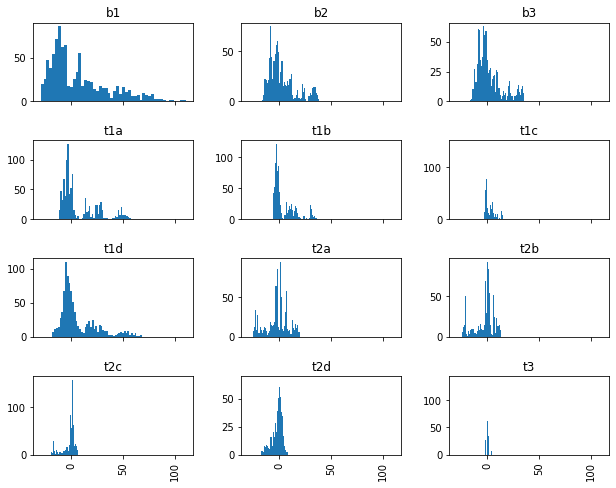

time: 6.49 s (started: 2023-02-23 18:46:08 +09:00)


In [136]:
_ = df_compare.hist(by='scenario', column='return', figsize=(10,8), bins=50, sharex=True)
#plt.tight_layout()

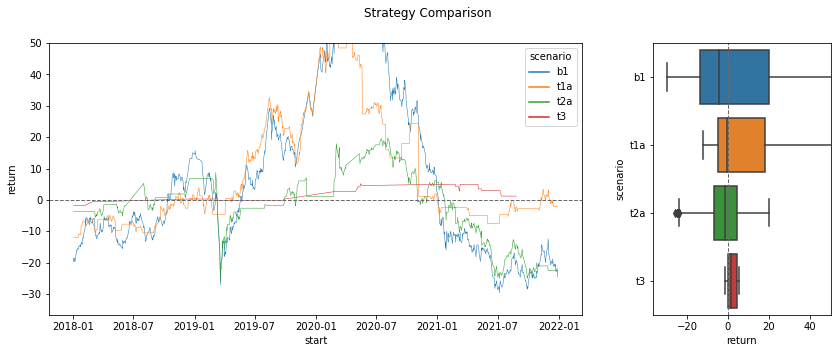

time: 1.46 s (started: 2023-02-23 20:27:31 +09:00)


In [165]:
ret_limit = 50
kw_axline = dict(lw=1, ls='--', c='dimgray')

fig = plt.figure(figsize=(14, 5))
fig.suptitle("Strategy Comparison")
gs = GridSpec(1, 2, width_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0])
#ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax2 = fig.add_subplot(gs[1])
#fig.tight_layout()

df = (df_compare
      #.loc[df_compare.scenario.str.startswith('t2')]
      .loc[df_compare.scenario.isin(['b1', 't1a', 't2a', 't3'])]
      .dropna(subset='return').reset_index()
)
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, y='scenario', x='return', ax=ax2,
                orient='h'
               )

_ = ax1.axhline(**kw_axline)
_ = ax2.axvline(**kw_axline)
_ = ax1.set_ylim(top=ret_limit)
_ = ax2.set_xlim(right=ret_limit)

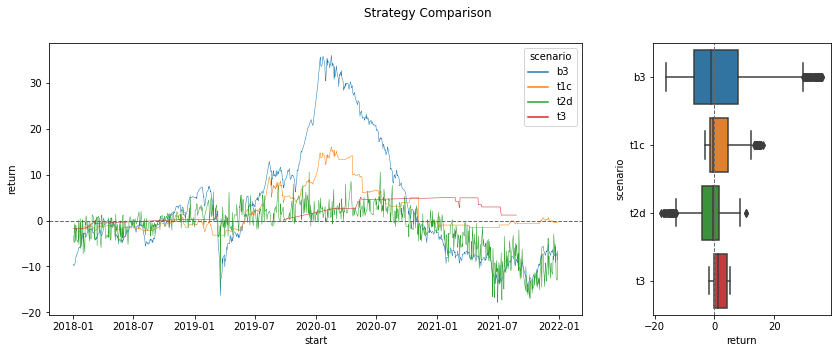

time: 1.42 s (started: 2023-02-23 20:58:09 +09:00)


In [167]:
ret_limit = None
kw_axline = dict(lw=1, ls='--', c='dimgray')

fig = plt.figure(figsize=(14, 5))
fig.suptitle("Strategy Comparison")
gs = GridSpec(1, 2, width_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0])
#ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax2 = fig.add_subplot(gs[1])
#fig.tight_layout()

df = (df_compare
      .loc[df_compare.scenario.isin(['b3', 't1c', 't2d', 't3'])]
      .dropna(subset='return').reset_index()
)
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
_ = sns.boxplot(data=df, y='scenario', x='return', ax=ax2,
                orient='h'
               )

_ = ax1.axhline(**kw_axline)
_ = ax2.axvline(**kw_axline)
_ = ax1.set_ylim(top=ret_limit)
_ = ax2.set_xlim(right=ret_limit)